In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, TwoSlopeNorm, BoundaryNorm
import matplotlib.colors as mcolors
import matplotlib.path as mpath
import matplotlib.patheffects as PathEffects
import matplotlib.dates as mdates
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable
from metpy.plots import USCOUNTIES
from matplotlib.colors import LogNorm

import numpy as np
import netCDF4 as nc
import xarray as xr
import os
import subprocess,sys
import matplotlib.colors as colors
import statistics as stats
from os import listdir
from os.path import isfile, join
import imageio
import h5py
import pyhdf
import sys
import statistics as stats

import configparser
import glob
from scipy.stats import linregress, pearsonr

from pyhdf.SD import *
from pyhdf.HDF import *
from pyhdf.VS import *
from read_hdf import hdf_get_vdata as hdf_get_vdata
from read_hdf import hdf_get_sds as hdf_get_sds

from parallax_correction import parallax_correct_clavrx
from sanitization import sanitize_clavrx
from hdf4_input import read

import warnings
import csv
import pandas as pd
from numpy.ma import masked_array

import pickle
import gc
from datetime import datetime, timedelta
import imageio

import datashader as ds
from datashader.mpl_ext import dsshow
import imageio
import seaborn as sns

from scipy.ndimage import binary_dilation
from scipy.interpolate import RegularGridInterpolator
from scipy import ndimage
from scipy.interpolate import griddata
from scipy.integrate import simpson

from pyresample import geometry, kd_tree

import re
import s3fs

from parallax_correction import parallax_correct_clavrx
from sanitization import sanitize_clavrx
from hdf4_input import read

from scipy.spatial import cKDTree, KDTree

from scipy.interpolate import interp1d

from matplotlib.gridspec import GridSpec

def normalize(value):
    return (value - min_val) / (max_val - min_val)

warnings.filterwarnings("ignore")

In [4]:
def add_cartopy_features(ax):
    #ax.add_feature(cfeature.OCEAN) #fills in the land when called after land
    #ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.COASTLINE)
    #ax.coastlines()
    #ax.add_feature(states110, zorder=1, linewidth=2.5)
    #ax.add_feature(USCOUNTIES.with_scale('500k'), linewidth=0.10, edgecolor='black')
        
states110 = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none',
            edgecolor='black')
def get_scatter(first_array,second_array):
    """
    first_array: 2d numpy array
    second_array: 2d numpy array

    clean_array_1: 1d array of cbh_array without nans
    clean_array_2: 1d array of cth_array without nans
    z: gaussian kde for scatter plot
    """
    mask = ~np.isnan(first_array.flatten()) & ~np.isnan(second_array.flatten())
    clean_array_1 = first_array.flatten()[mask]
    clean_array_2 = second_array.flatten()[mask]

    return clean_array_1,clean_array_2

def using_datashader(ax, x, y,vmaxx,wcmap):

    df = pd.DataFrame(dict(x=x, y=y))
    dsartist = dsshow(
        df,
        ds.Point("x", "y"),
        ds.count(),
        norm=LogNorm(vmin=1, vmax=vmaxx),
        aspect="auto",
        ax=ax,
        vmin=1,
        vmax=vmaxx,
        cmap=wcmap,
    )

    return dsartist

def read_resampled_clavrx_h5(f, varname):
    '''
    Read variable from composite file.

    Parameters
    ----------
    f : h5py.File 
        File object created with "f = h5py.File(path, 'r')"
    varname : str
        name of variable to read from file.
    Returns
    -------
    var_arary : np.array (float32)
        numpy array containing scaled and missing-filled values
    '''

    var = f[varname]
    var_array = np.array(f[varname][:], dtype='float32')    
    if '_FillValue' in var.attrs:
        fv = var.attrs['_FillValue']
        var_array[var_array==fv] = np.nan
    if 'actual_missing' in var.attrs:
        am = var.attrs['actual_missing']
        var_array[var_array==am] = np.nan
    if 'SCALED' in var.attrs:
        if var.attrs['SCALED']==1:
            sf = var.attrs['scale_factor']
            ao = var.attrs['add_offset']
            var_array = var_array*sf + ao
    if 'actual_range' in var.attrs:
        actual_min = var.attrs['actual_range'][0]
        actual_max = var.attrs['actual_range'][1]
        var_array[var_array<actual_min] = np.nan
        var_array[var_array>actual_max] = np.nan
    return var_array

def make2d(lat, lon, row_inds, col_inds, var_array):
    col_ind_wraparound = col_inds==lon.shape[0]
    col_inds[col_ind_wraparound] = 0
    field_2d = np.zeros([lat.shape[0], lon.shape[0]])
    field_2d.fill(np.nan)
    field_2d[row_inds, col_inds] = var_array
    return field_2d

def read_leo_data(date_string,node,instrument):
    path_to_composite = f'/mnt/overcastnas1/cwhite/blending_validation/clavrx_composite/{instrument}/{date_string}/{instrument}_composite_{node}_{date_string}.h5'

    # Read in the LEO composite (hdf5)
    f = h5py.File(path_to_composite, 'r')
    data = {}
    for key in vars_to_read:
        if key in list(f.keys()): data[key] = read_resampled_clavrx_h5(f, key)
        else: print(f'Skipping {key} ... in the LEO file')
    
    # Turn indices into int
    data['ovc_row_ind'] = data['ovc_row_ind'].astype('int')
    data['ovc_col_ind'] = data['ovc_col_ind'].astype('int')
    #data['ovc_row_ind_cp'] = data['ovc_row_ind_cp'].astype('int')
    #data['ovc_col_ind_cp'] = data['ovc_col_ind_cp'].astype('int')
    
    # Get the Grid information from the attributes and create grid
    ovc_res = f.attrs['grid.ovc_res'] # resolution of the overcast-like grid (regularly-spaced 0.02 deg)
    max_ovc_lat = f.attrs['grid.max_lat'] # max and min latitude extent of 2D Grid
    min_ovc_lat = f.attrs['grid.min_lat']
    max_ovc_lon = f.attrs['grid.max_lon'] # max and min longitude extent of 2D Grid
    min_ovc_lon = f.attrs['grid.min_lon'] 
    ovc_lat = f['ovc_lat_grid'][:] # 1D array that tells us the row latitudes of the 2D grid
    ovc_lon = f['ovc_lon_grid'][:] # 1D array that tells us the column longitudes of the 2D grid
    #print(list(f.keys()))
    
    #data['clavrx_filename_list'] = f['clavrx_filename_list'][:]
    #print(f.keys(),'\n')
    # Close the hdf5 file
    f.close()

    return data, ovc_lat, ovc_lon

def read_geo_data(date_string,node,instrument,from_chuck=True):
    
    # Read in the GEO composite
    if from_chuck:
        path_to_composite = f'/mnt/overcastnas1/cwhite/blending_validation/clavrx_composite/{instrument}/{date_string}/GEOMATCH_{instrument}_composite_{node}_{date_string}.h5'
    else:
        path_to_composite = f'/mnt/sat/overcast/cjohnson/G16_limb_matchups/{date_string}/G16_limb_matchup_{instrument}_composite_{node}_{date_string}.h5'
    f = h5py.File(path_to_composite, 'r')
    geo_data = {}
    for key in vars_to_read:
        if key in list(f.keys()):
            geo_data[key] = read_resampled_clavrx_h5(f, key)
        else:
            print(f'Skipping {key}... in the GEO file')
    geo_data['ovc_row_ind'] = geo_data['ovc_row_ind'].astype('int')
    geo_data['ovc_col_ind'] = geo_data['ovc_col_ind'].astype('int')
    #geo_data['clavrx_filename_list'] = f['clavrx_filename_list'][:]
    #print(f.keys())
    f.close()

    return geo_data

def nan_to_999(array_or_dataset_object):
    array = np.array(array_or_dataset_object)
    nan_true = np.isnan(array)
    array[nan_true] = -999
    return array

def data_info(dataset_name,hdf): 
    data = hdf.select(dataset_name)
    data_array = data[:]
    attributes = data.attributes()

    masked_array = np.where(data_array == attributes['_FillValue'], np.nan, data_array)

    final_array = masked_array * attributes['scale_factor'] + attributes['add_offset']

    return final_array,attributes

def data_for_coords(dataset_name,hdf): 
    data = hdf.select(dataset_name)
    data_array = data[:]
    attributes = data.attributes()

    #masked_array = np.where(data_array == attributes['_FillValue'], np.nan, data_array)

    final_array = data_array * attributes['scale_factor'] + attributes['add_offset']

    return final_array,attributes

def read_eca_var(f, varname):
    var_array = f[varname][:].astype('float64')
    if '_FillValue' in f[varname].attrs:
        fv = f[varname].attrs['_FillValue']
        var_array[var_array==fv] = np.nan
    var_array = var_array.astype('float64')
    return var_array

def strip_prefix(data, prefixes=[]):
    # Note that prefixes needs to be in order if both are present
    for prefix in prefixes:
        for var in list(data.keys()):
            if var.startswith(prefix):
                num_char = len(prefix)
                new_varname = var[num_char:]
                data[new_varname] = data.pop(var)
    return data

def get_julian_and_decimal_hour(seconds_array):
    dt_index = pd.to_datetime(seconds_array, unit='s', origin='2000-01-01')
    julian_days = dt_index.dayofyear 
    decimal_hours = (dt_index.hour +
                     dt_index.minute / 60.0 +
                     dt_index.second / 3600.0 +
                     dt_index.microsecond / (3600.0 * 1e6))
    return julian_days.to_numpy(), decimal_hours.to_numpy()

def read_all_atlid(atl_filename, varnames):
    f_atl = h5py.File(atl_filename, 'r')
    data_atl = {}
    for var in varnames:
        data_atl[var] = read_eca_var(f_atl, var)
    f_atl.close()
    
    # Convert seconds since epoch start to decimal hour
    data_atl['julian_day'], data_atl['time_decimal_hour'] = get_julian_and_decimal_hour(data_atl['ScienceData/time'])

    # Remove extra naming
    data_atl = strip_prefix(data_atl, ['ScienceData/', 'ATLID_'])
    data_atl['profile_index'] = np.arange(len(data_atl['latitude']))
    return data_atl

In [3]:
#cth path

# case study 1
atl_pathname = '/mnt/sat/earthcare/ATL_CTH_2A/AE/2025/03/12/ECA_EXAE_ATL_CTH_2A_20250312T135312Z_20250312T153620Z_04475E.h5'
atl_ebd_path = '/mnt/sat/earthcare/ATL_EBD_2A/AG/2025/06/

# case study 2
atl_pathname = 
atl_ebd_path = 

# case study 3
atl_pathname = '/mnt/sat/earthcare/ATL_CTH_2A/AE/2025/06/24/ECA_EXAE_ATL_CTH_2A_20250624T033954Z_20250625T085527Z_06087B.h5'
atl_ebd_path = '/mnt/sat/earthcare/ATL_EBD_2A/AG/2025/06/24/ECA_EXAG_ATL_EBD_2A_20250624T033954Z_20250625T085130Z_06087B.h5'


In [21]:
ebd_test = '/mnt/sat/earthcare/ATL_EBD_2A/AG/2025/06/'
ebd_yearday = ebd_test[-9:]

atl_test = '/mnt/sat/earthcare/ATL_CTH_2A/AE/'

for day in sorted(os.listdir(ebd_test)):
    date_check = ebd_yearday + day + '/'

    for file in sorted(os.listdir(ebd_test + day + '/')): # check the filename for ebd
        if file.endswith('.h5'):
            file_end = file[-9:]

            if os.path.exists(atl_test + date_check): # check the filename for atl
                for file in sorted(os.listdir(atl_test + date_check)):
                    if file.endswith(file_end):
                        print(date_check, ' passes')

            
    
    # assert os.path.exists(atl_test + date_check), f'path does not exist: {date_check}'

    # print(f"Path '{date_check}' exists.")

/2025/06/11/  passes
/2025/06/11/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/  passes
/2025/06/12/ 

In [4]:
#----- data from ATL EBD
with h5py.File(atl_ebd_path, 'r') as f:
    
    dataset_path = 'ScienceData/particle_optical_depth_355nm'
    opd_data = np.array(f[dataset_path][()])

    time_path = 'ScienceData/time'
    time_ebd_data = np.array(f[time_path][()])

    lat_path = 'ScienceData/latitude'
    lat_ebd_data = np.array(f[lat_path][()])

    lon_path = 'ScienceData/longitude'
    lon_ebd_data = np.array(f[lon_path][()])

    height_path = 'ScienceData/height'
    ebd_height_data = np.array(f[height_path][()]) / 1000


lat_ebd_grid, height_ebd_grid = np.meshgrid(lat_ebd_data, np.arange(ebd_height_data.shape[1]), indexing='ij')

In [5]:
with h5py.File(atl_pathname, 'r') as f:
    
    dataset_path = 'ScienceData/ATLID_cloud_top_height'
    cth_data = np.array(f[dataset_path][()]) / 1000 # conv to km

    time_path = 'ScienceData/time'
    time_data = np.array(f[time_path][()])

    lat_path = 'ScienceData/latitude'
    ec_lat = np.array(f[lat_path][()])

    lon_path = 'ScienceData/longitude'
    ec_lon = np.array(f[lon_path][()])

    

ec_cth = np.where(cth_data != 9.96921e+36, cth_data, np.nan)

# ec_lat = lat_data[mask]
# ec_lon = lon_data[mask]

ref_time = datetime(2000, 1, 1, 0, 0, 0)
cth_time = [ref_time + timedelta(seconds=sec) for sec in time_data]

print(cth_time[0],'\n',cth_time[-1])

2025-06-24 03:39:45.746574 
 2025-06-24 03:51:59.610449


3.662707381666667 3.866558457777778


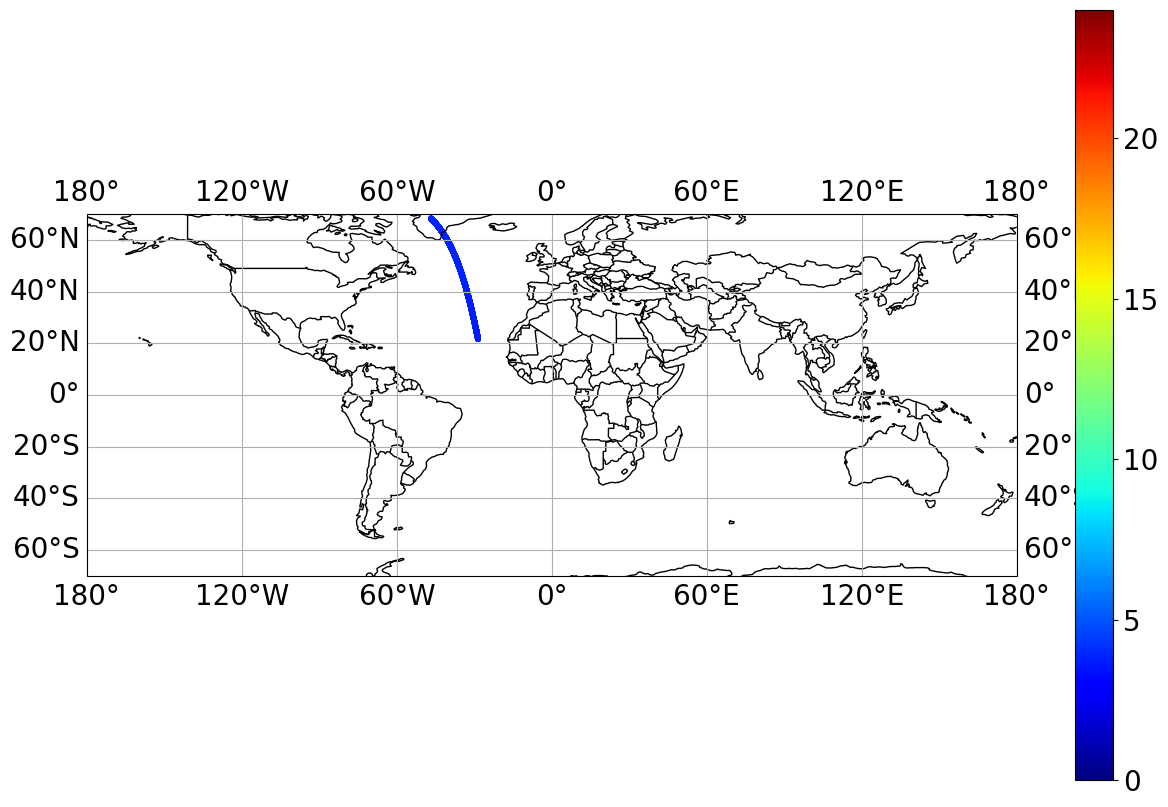

In [6]:
# atl_path_to = '/mnt/sat/earthcare/ATL_CTH_2A/AE/2025/06/24/'

varnames = ['ScienceData/ATLID_cloud_top_height',
            'ScienceData/ATLID_thick_cloud_top_height',
            'ScienceData/quality_status',
            'ScienceData/latitude',
            'ScienceData/longitude',
            'ScienceData/time']

data_use = read_all_atlid(atl_filename=atl_pathname, varnames=varnames)

print(data_use['time_decimal_hour'].min(), data_use['time_decimal_hour'].max())
#print(filenamee[i])
fig = plt.figure(figsize=(15,10),transform=ccrs.PlateCarree)

plt.rcParams.update({'font.size': 20})

ax1 = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax1.set_extent([-180,180,-70,70], ccrs.PlateCarree())
ax1.add_feature(cfeature.BORDERS)
ax1.add_feature(cfeature.COASTLINE)
ax1.gridlines(draw_labels=True)
cs = ax1.scatter(data_use['longitude'],data_use['latitude'], c= data_use['time_decimal_hour'],s=10,
               transform=ccrs.PlateCarree(), vmin=0,vmax=24,cmap='jet')
    
plt.colorbar(cs)

plt.show()

In [7]:
#data paths
g19_path = '/mnt/overcastnas1/GEO_clavrx/GOES19_ABI/RadF/output/2025175/clavrx_OR_ABI-L1b-RadF-M6C01_G19_s20251750350202.level2.hdf'


CLAVRX_VARS = ["sensor_azimuth_angle",
               "sensor_zenith_angle",
               "surface_elevation",
               "cloud_phase",
               "cld_height_base",
               "cld_height_acha",
              "cld_opd_acha"]

# ------ read in g16/m10 data ------
read_g19_data = read(g19_path, var_names=CLAVRX_VARS)

# ------ sanitize, parallax ------
#g16
sanit_g19 = sanitize_clavrx(read_g19_data)
par_g19 = parallax_correct_clavrx(sanit_g19)

lat_g19 = np.array(par_g19['pc_latitude'])
lon_g19 = np.array(par_g19['pc_longitude'])
cth_g19 = np.array(par_g19['cld_height_acha'])
senz_g19 = np.array(par_g19['sensor_zenith_angle'])
opd_g19 = np.array(par_g19['cld_opd_acha'])



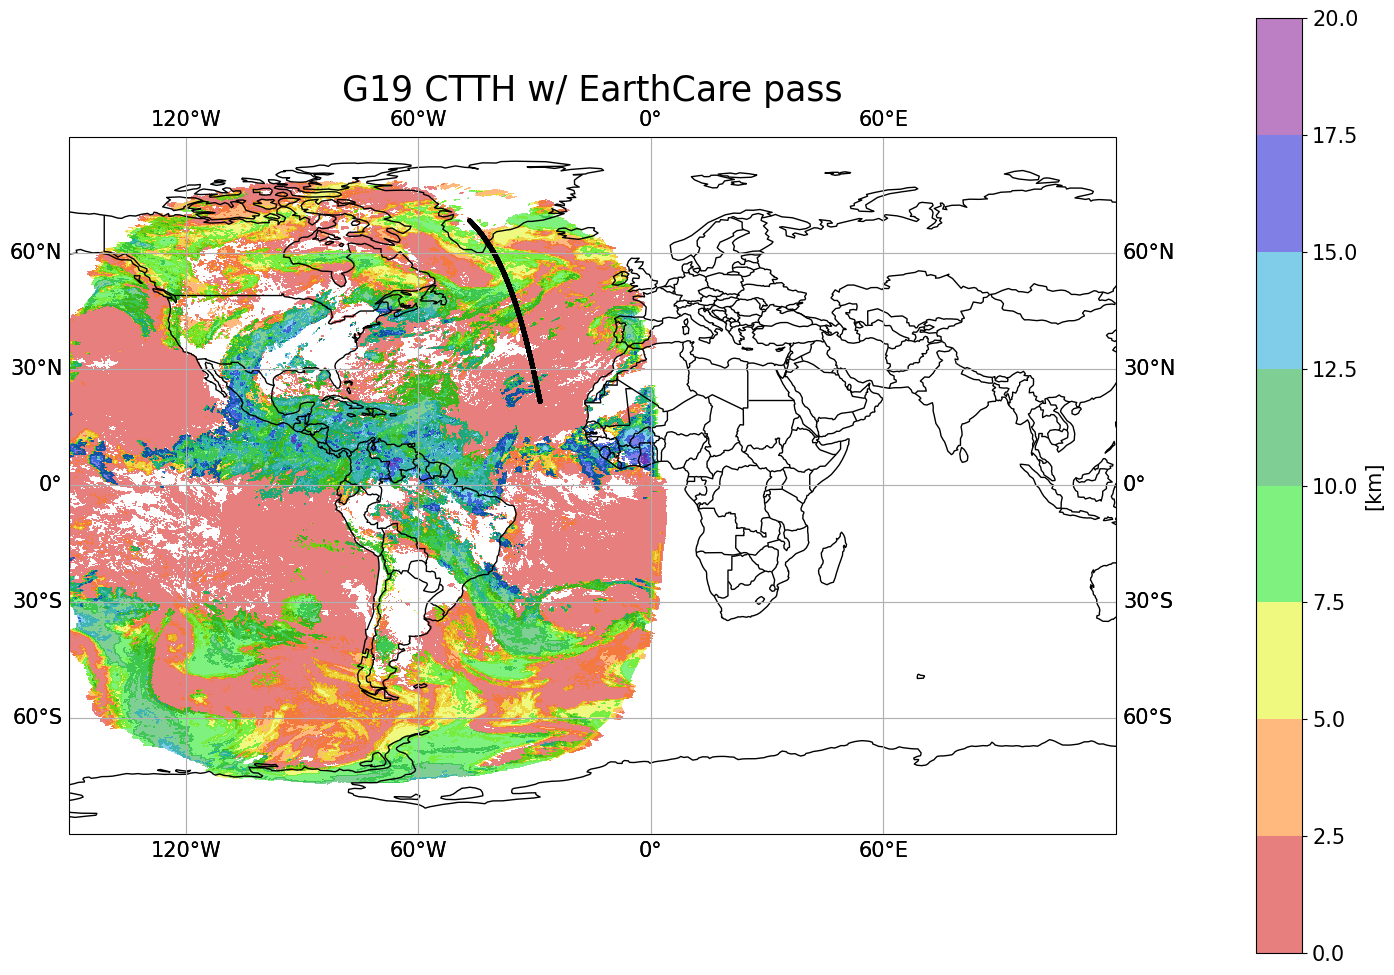

In [35]:
save = True

fig = plt.figure(figsize=(15,10),transform=ccrs.PlateCarree)

plt.rcParams.update({'font.size': 15})

ax1 = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=0))

ax1.set_extent([-150, 120, -90, 90], ccrs.PlateCarree())

ax1.add_feature(cfeature.BORDERS)
ax1.add_feature(cfeature.COASTLINE)
ax1.gridlines(draw_labels=True)


cs1 = ax1.contourf(lon_g19,
                     lat_g19,
                     cth_g19,
                     cmap='nipy_spectral_r', transform=ccrs.PlateCarree(),alpha=0.5)

cs = ax1.scatter(data_use['longitude'],data_use['latitude'], 
                 c= data_use['time_decimal_hour'],s=5,
                   transform=ccrs.PlateCarree(),cmap=ListedColormap(['black']))


plt.colorbar(label='[km]', orientation='vertical', mappable = cs1, pad = 0.1)

ax1.set_title(f'G19 CTTH w/ EarthCare pass',fontsize=25)
ax1.gridlines(draw_labels=True,alpha=0.25)

plt.tight_layout()

if save:
    plt.savefig('/home/cjohnson/geos_leo/figs/g19_cth_with_ec_location.png',bbox_inches='tight')
else:
    plt.show()



# regrid G19 to EC

In [9]:
# regrid the geo...
#g19
lat_g19_flat = lat_g19.ravel()
lon_g19_flat = lon_g19.ravel()
cth_g19_flat = cth_g19.ravel()
opd_g19_flat = opd_g19.ravel()


# Create a valid mask
valid_g19_mask = (~np.isnan(lat_g19_flat) & 
                  ~np.isnan(lon_g19_flat) & 
                  ~np.isnan(cth_g19_flat) &
                  ~np.isnan(opd_g19_flat))


# Filter valid points
lat_valid_g19 = lat_g19_flat[valid_g19_mask]
lon_valid_g19 = lon_g19_flat[valid_g19_mask]
cth_valid_g19 = cth_g19_flat[valid_g19_mask]
opd_valid_g19 = opd_g19_flat[valid_g19_mask]


# Combine GEO lat/lon into a single array for tree
g19_points = np.column_stack((lat_valid_g19, lon_valid_g19))
g19_tree = KDTree(g19_points, leafsize=25)


# Prepare your 1D points - from EC
line_points = np.column_stack((data_use['latitude'], data_use['longitude']))

# Find nearest neighbors in the GEO field
# ------ chuck's routine below:
distances_g19, indices_g19 = g19_tree.query(line_points,1)

collocated_cth_g19 = cth_valid_g19[indices_g19]
collocated_opd_g19 = opd_valid_g19[indices_g19]



valid_mask_g19 = ~np.isnan(data_use['cloud_top_height']) & ~np.isnan(collocated_cth_g19) & ~np.isnan(collocated_opd_g19)


# g19
cth_ec_valid = data_use['cloud_top_height'][valid_mask_g19] / 1000
opd_ec_valid = opd_data[valid_mask_g19, :]

cth_g19_valid = collocated_cth_g19[valid_mask_g19]
opd_g19_valid = collocated_opd_g19[valid_mask_g19]

lat_1d_ec_valid = data_use['latitude'][valid_mask_g19]
lon_1d_ec_valid = data_use['longitude'][valid_mask_g19]
height_1d_ec_valid = ebd_height_data[valid_mask_g19,:]

cth_g19_valid.shape

(4645,)

In [10]:
print(cth_ec_valid.shape,
      cth_g19_valid.shape,
      opd_g19_valid.shape,
      lat_1d_ec_valid.shape,
      lon_1d_ec_valid.shape,
      height_1d_ec_valid.shape
     )

(4645,) (4645,) (4645,) (4645,) (4645,) (4645, 242)


In [11]:
opd_data.shape

(5344, 242)

In [12]:
ec_cth.shape

(5344,)

In [13]:
data_use['cloud_top_height'].shape

(5344,)

In [14]:
opd_ec_valid.shape

(4645, 242)

In [15]:
ebd_height_data.shape

(5344, 242)

In [16]:
# Step 1: Replace fill values with NaN in OPD
opd_masked = np.where(opd_ec_valid < 1000, opd_ec_valid, np.nan)

# Step 2: Create mask where height is above the CTH
mask_above_cth = height_1d_ec_valid > cth_ec_valid[:, np.newaxis]  # (4645, 242)

# Step 3: Mask out OPD above CTH
opd_below_cth = np.where(mask_above_cth, np.nan, opd_masked)


# redo for g19 cth
mask_above_cth_g19 = height_1d_ec_valid > cth_g19_valid[:, np.newaxis]
opd_below_cth_g19 = np.where(mask_above_cth_g19, np.nan, opd_masked)

# Step 4: Optionally mask entire profiles where CTH is invalid
# valid_cth_mask = ~np.isnan(ec_cth)
# opd_final = np.where(valid_cth_mask[:, np.newaxis], opd_below_cth, np.nan)


In [17]:
# get meshgrid for latitude for ec
new_ec_lat, height_ebd_grid = np.meshgrid(lat_1d_ec_valid, 
                                          np.arange(ebd_height_data.shape[1]), 
                                          indexing='ij')

#calculate opd and mask values for 1d array
#masked_valid_ec = np.where(opd_ec_valid < 1000, opd_ec_valid, np.nan)
max_ec_opd = np.nanmin(opd_below_cth, axis=1)

max_g19_opd = np.nanmin(opd_below_cth_g19, axis=1)

In [18]:
max_ec_opd == max_g19_opd

array([False, False, False, ..., False, False, False])

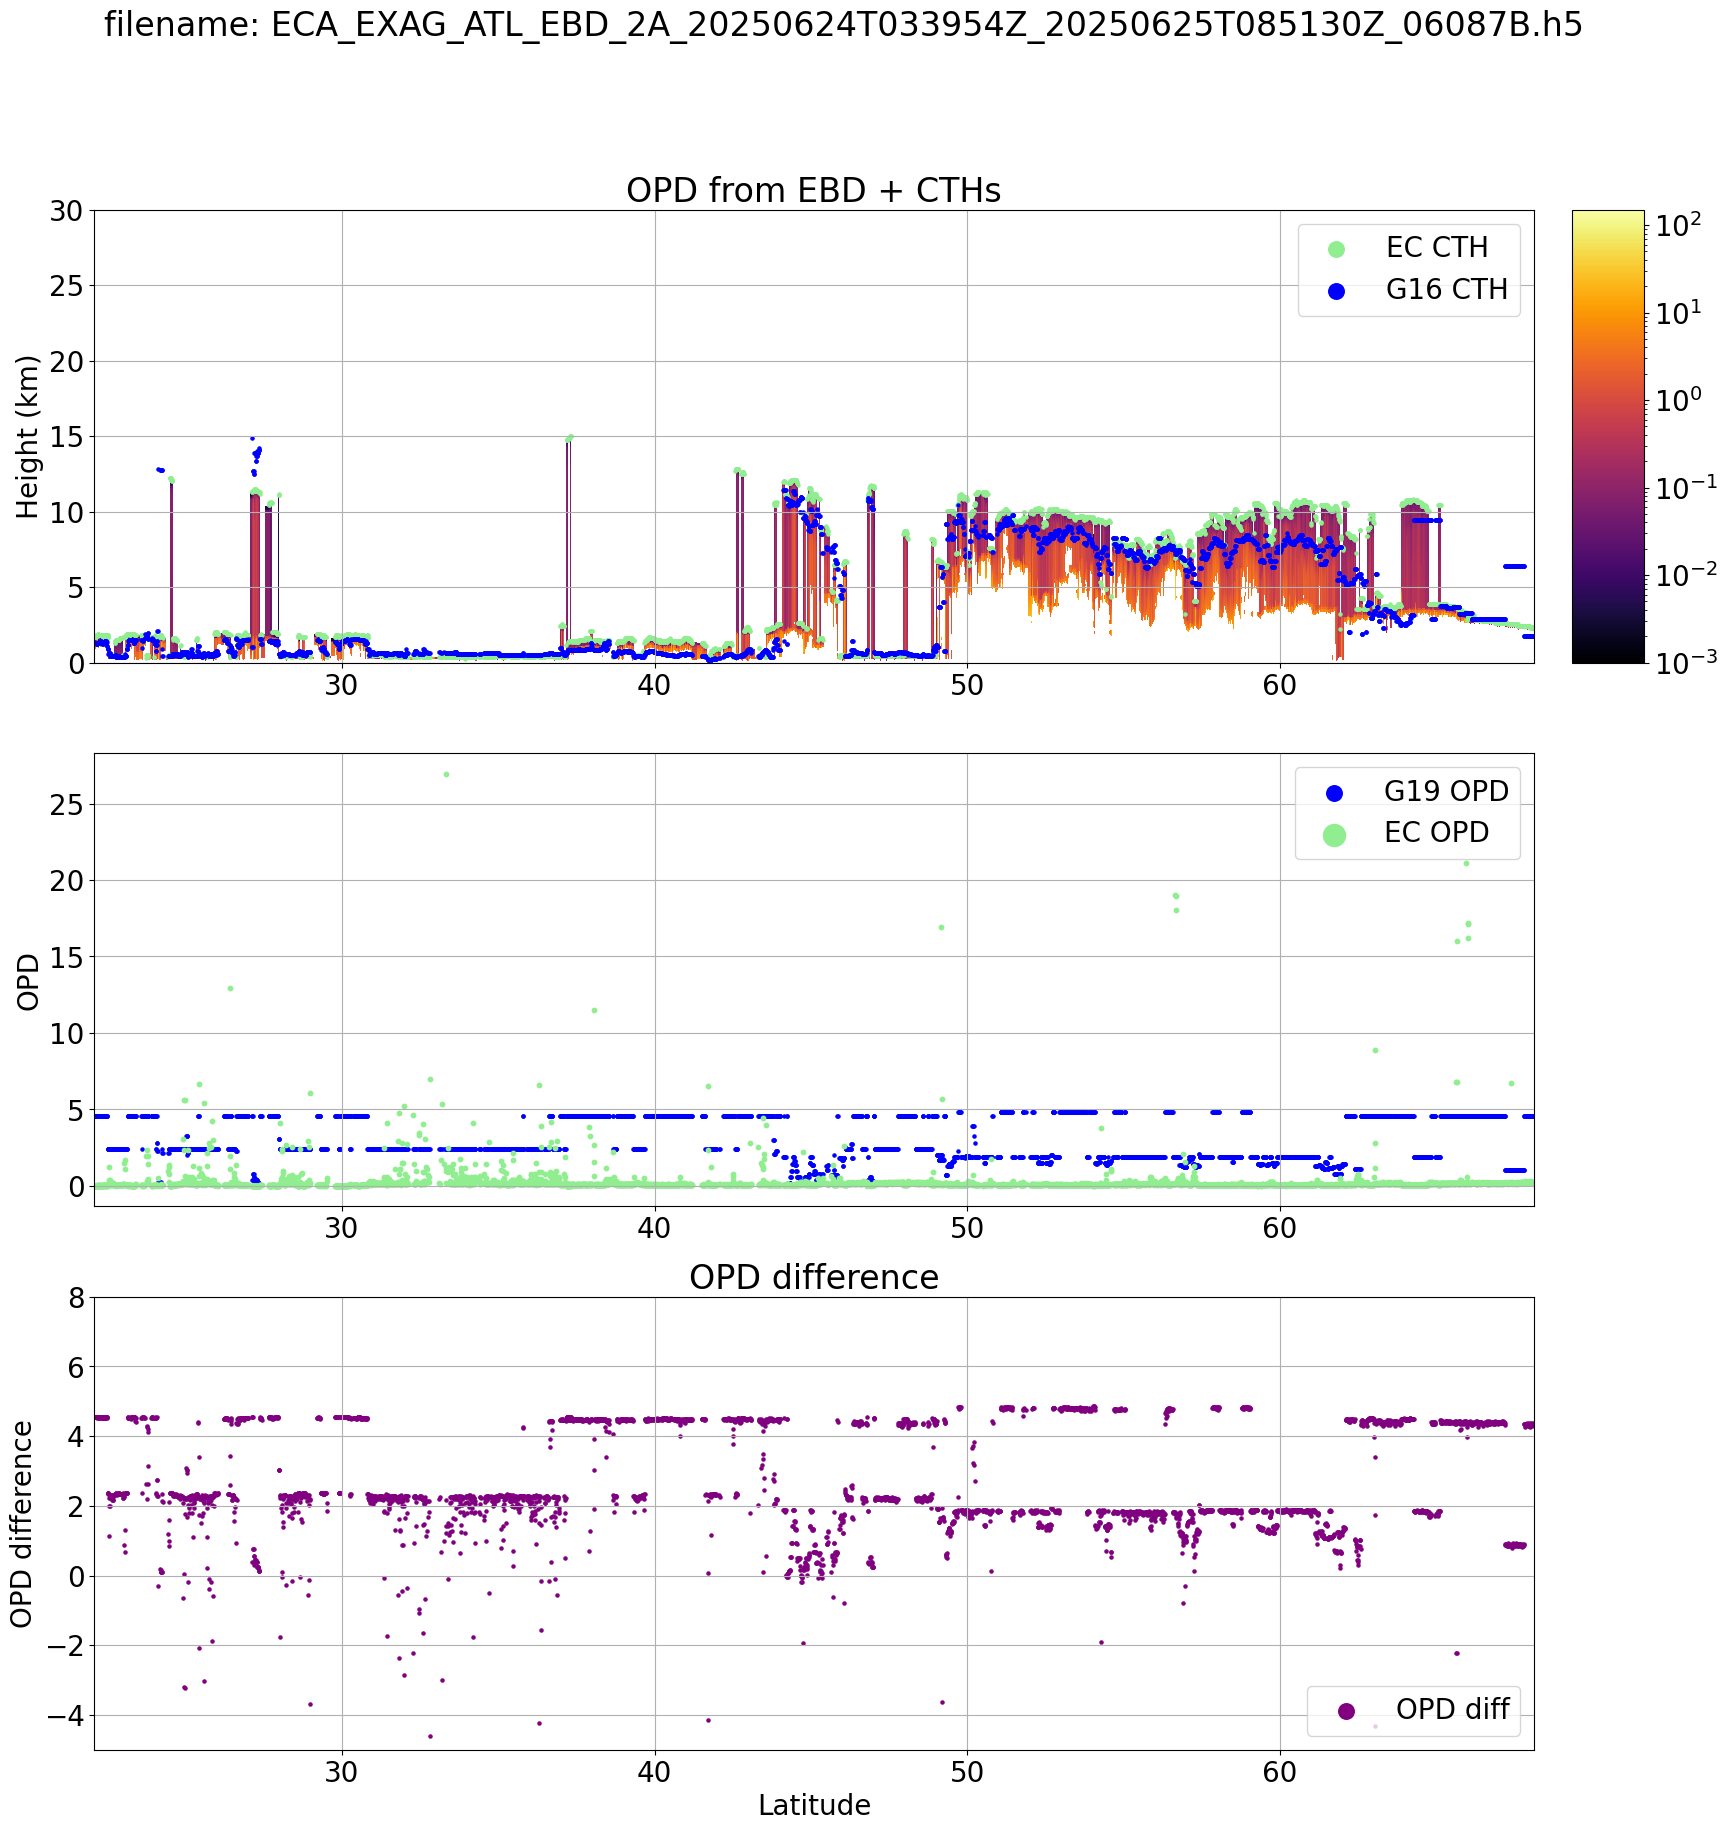

In [60]:
save = True

# fig, ax = plt.subplots(figsize=(15, 5))
fig = plt.figure(figsize=(20,20))
plt.rcParams.update({'font.size': 20})

gs = GridSpec(3, 2, width_ratios=[20, 1], height_ratios=[1, 1, 1], wspace=0.05, hspace=0.2)


ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)  # New axis aligned below ax2
cax = fig.add_subplot(gs[0, 1])  # Colorbar axis aligned with ax1

pcm = ax1.pcolormesh(new_ec_lat, height_1d_ec_valid, opd_below_cth, cmap='inferno', 
                    norm=LogNorm(vmin=0.001, vmax=150))

ax1.scatter(lat_1d_ec_valid, cth_ec_valid, color='lightgreen', marker='o', s=5, label="EC CTH")
ax1.scatter(lat_1d_ec_valid, cth_g19_valid, color='blue',marker='o',s=5,label='G16 CTH')

cbar = plt.colorbar(mappable = pcm,cax=cax,orientation='vertical',ax=ax1)

# ax1.scatter(ec_lat, ec_cth, color='red', marker='o', s=2, label="CTH product")
# ax1.scatter(ec_lat, max_height_interp,color='blue',marker='o',s=2,label='Max CTH from lidar')


legend = ax1.legend(
    fontsize=20,         # makes the text labels bigger
    markerscale=5,       # makes the markers 2x larger
    handlelength=2,      # length of the legend handles (horizontal spacing)
    handletextpad=0.8,    # space between marker and text
    loc='upper right'
)

ax1.set_title("OPD from EBD + CTHs")
ax1.set_xlabel("")
ax1.set_ylabel("Height (km)")

# plt.text(-20,30,f'RMSE: {np.round(rmse,2)}\nr: {np.round(r,2)}',fontsize=15)

ax1.grid()
ax1.set_ylim(0,30)

# just scatter the opd

# top --> when you grab opd straight from g19 and regrid it
# bottom --> when you grab opd from EC
ax2.scatter(lat_1d_ec_valid, opd_g19_valid, color='blue',marker='o',s=5,label='G19 OPD')
# ax2.scatter(lat_1d_ec_valid, max_g19_opd, color='blue',marker='o',s=10,label='G19 OPD')
ax2.scatter(lat_1d_ec_valid, max_ec_opd, color='lightgreen',marker='o',s=10,label='EC OPD')

legend = ax2.legend(
    fontsize=20,         # makes the text labels bigger
    markerscale=5,       # makes the markers 2x larger
    handlelength=2,      # length of the legend handles (horizontal spacing)
    handletextpad=0.8,    # space between marker and text
    loc='upper right'
)

ax2.set_title("")
ax2.set_xlabel("")
ax2.set_ylabel("OPD")
ax2.grid()

# the opd difference
# ax3.scatter(lat_1d_ec_valid, max_g19_opd - max_ec_opd, color='purple',marker='o',s=10,label='G19 - EC OPD')
ax3.scatter(lat_1d_ec_valid, opd_g19_valid - max_ec_opd, color='purple',marker='o',s=5,label='OPD diff')



legend = ax3.legend(
    fontsize=20,         # makes the text labels bigger
    markerscale=5,       # makes the markers 2x larger
    handlelength=2,      # length of the legend handles (horizontal spacing)
    handletextpad=0.8,    # space between marker and text
    loc='lower right'
)

ax3.set_title("OPD difference")
ax3.set_xlabel("Latitude")
ax3.set_ylabel("OPD difference")
ax3.grid()
# ax2.set_title('Column integrated OPD')
ax3.set_ylim(-5,8)

plt.suptitle(f'filename: {atl_ebd_path[-63:]}')
plt.tight_layout()


if save:
    plt.savefig('/home/cjohnson/geos_leo/figs/opd_from_other.png',bbox_inches='tight')
else:
    plt.show()

In [59]:
opd_diff_ebd = max_g19_opd - max_ec_opd

opd_diff_other = opd_g19_valid - max_ec_opd

print(np.nanmin(opd_diff_ebd),
      np.nanmax(opd_diff_ebd),
      np.nanmean(opd_diff_ebd))

print(np.nanmin(opd_diff_other),
      np.nanmax(opd_diff_other),
      np.nanmean(opd_diff_other))

-6.578168 35.88838 0.7421644
-24.586088 4.8509564 2.7812793


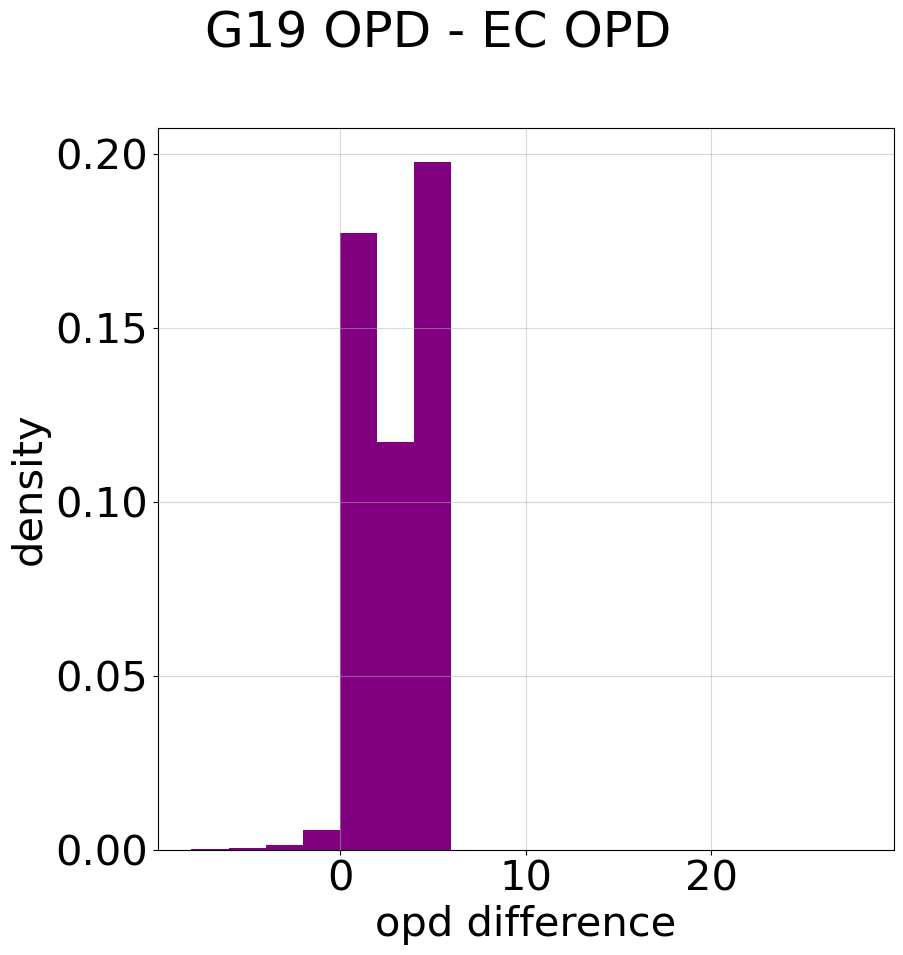

In [64]:
# Histogram for cth first

save = True
fig = plt.figure(figsize=(10,10))

bin_edges = np.arange(-8, 30, 2)

ax1 = plt.subplot(1, 1, 1)

ax1.hist(np.array(opd_diff_other),density=True,color='purple',bins=bin_edges)

ax1.grid(alpha=0.5)


ax1.set_ylabel('density')

ax1.set_xlabel('opd difference')

#ax1.set_xlim(0,25)

#ax1.legend()

#ax1.set_ylim(0,0.2)

plt.suptitle('G19 OPD - EC OPD')
plt.rcParams.update({'font.size': 30})

plt.tight_layout()

if save:
    plt.savefig('/home/cjohnson/geos_leo/figs/opd_hist.png',bbox_inches='tight')
else:
    plt.show()

# a different approach -- pull out g19's opd from ec, not from g19

In [56]:
# Step 1: Compute index of closest height to CTH
indices_cth_ec = np.abs(height_1d_ec_valid - cth_ec_valid[:, None]).argmin(axis=1)
# indices_cth_g19 = np.abs(ebd_height_data - collocated_cth_g19[:, None]).argmin(axis=1)

# Step 2: Use these indices to extract the matching optical depth
opd_at_ec = opd_below_cth[np.arange(4645), indices_cth_ec]
# opd_at_g19 = opd_final[np.arange(5344), indices_cth_g19]

valid_mask = ~np.isnan(cth_g19_valid)

# Apply only where valid
indices_cth_g19 = np.full_like(cth_g19_valid, fill_value=-1, dtype=int)

indices_cth_g19[valid_mask] = np.abs(
    height_1d_ec_valid[valid_mask] - cth_g19_valid[valid_mask, None]
).argmin(axis=1)

opd_at_g19 = np.full_like(cth_g19_valid, fill_value=np.nan)
opd_at_g19[valid_mask] = opd_below_cth[valid_mask, indices_cth_g19[valid_mask]]

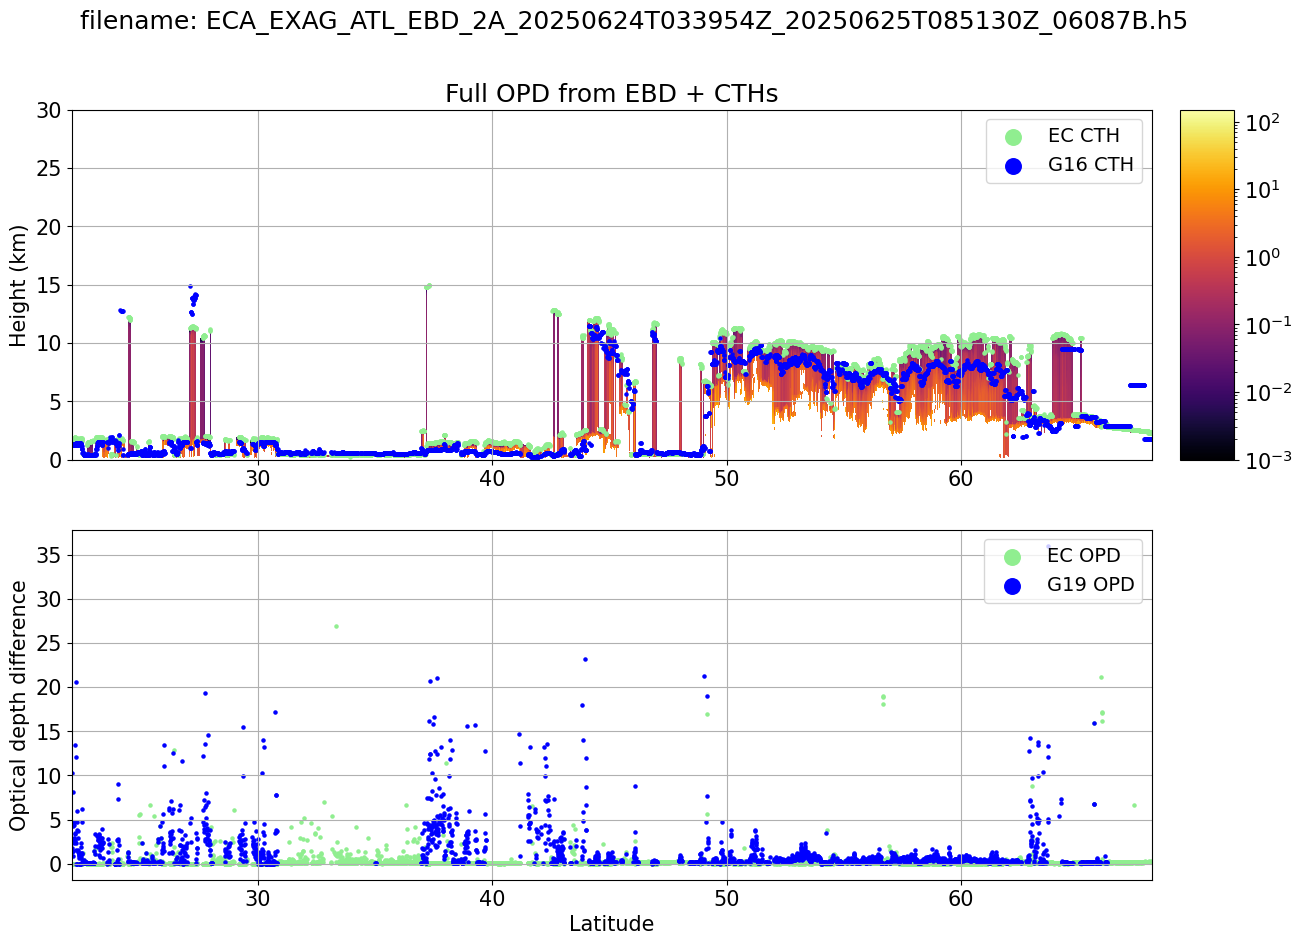

In [57]:
save = False

# fig, ax = plt.subplots(figsize=(15, 5))
fig = plt.figure(figsize=(15,10))
gs = GridSpec(2, 2, width_ratios=[20, 1], height_ratios=[1, 1], wspace=0.05, hspace=0.2)


ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
cax = fig.add_subplot(gs[0, 1])  # Colorbar axis aligned with ax1

pcm = ax1.pcolormesh(new_ec_lat, height_1d_ec_valid, opd_below_cth, cmap='inferno', 
                    norm=LogNorm(vmin=0.001, vmax=150))

ax1.scatter(lat_1d_ec_valid, cth_ec_valid, color='lightgreen', marker='o', s=5, label="EC CTH")
ax1.scatter(lat_1d_ec_valid, cth_g19_valid, color='blue',marker='o',s=5,label='G16 CTH')

cbar = plt.colorbar(mappable = pcm,cax=cax,orientation='vertical',ax=ax1)

# ax1.scatter(ec_lat, ec_cth, color='red', marker='o', s=2, label="CTH product")
# ax1.scatter(ec_lat, max_height_interp,color='blue',marker='o',s=2,label='Max CTH from lidar')


legend = ax1.legend(
    fontsize=14,         # makes the text labels bigger
    markerscale=5,       # makes the markers 2x larger
    handlelength=2,      # length of the legend handles (horizontal spacing)
    handletextpad=0.8,    # space between marker and text
    loc='upper right'
)

ax1.set_title("Full OPD from EBD + CTHs")
ax1.set_xlabel("")
ax1.set_ylabel("Height (km)")

# plt.text(-20,30,f'RMSE: {np.round(rmse,2)}\nr: {np.round(r,2)}',fontsize=15)

ax1.grid()
ax1.set_ylim(0,30)

ax2.scatter(lat_1d_ec_valid, max_ec_opd, color='lightgreen',marker='o',s=5,label='EC OPD')
ax2.scatter(lat_1d_ec_valid, opd_at_g19, color='blue',marker='o',s=5,label='G19 OPD')



legend = ax2.legend(
    fontsize=14,         # makes the text labels bigger
    markerscale=5,       # makes the markers 2x larger
    handlelength=2,      # length of the legend handles (horizontal spacing)
    handletextpad=0.8,    # space between marker and text
    loc='upper right'
)

ax2.set_title("")
ax2.set_xlabel("Latitude")
ax2.set_ylabel("Optical depth difference")
ax2.grid()
# ax2.set_title('Column integrated OPD')

plt.suptitle(f'filename: {atl_ebd_path[-63:]}')

plt.tight_layout()

if save:
    plt.savefig('/home/cjohnson/geos_leo/figs/subsetted_opd_350.png',bbox_inches='tight')
else:
    plt.show()

In [59]:
np.nanmin(opd_at_g19)

np.float32(0.0)